In [ ]:
# colab setup if needed
!pip install Box2D
!pip install gym[box2d] pyvirtualdisplay 
!pip install box2d-py
!apt update
!apt install -y xvfb python-opengl ffmpeg

In [1]:
import gym
import time
import copy
import random

import numpy as np
import matplotlib.pyplot as plt

from collections import deque
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

%matplotlib inline

In [ ]:
class ExpirienceReplay:
    def __init__(self, size=10000):
        self.data = deque(maxlen=size)
    
    def add(self, transition):
        self.data.append(transition)
        
    def sample(self, size):
        batch = random.sample(self.data, size)
        return list(zip(*batch))

In [ ]:
def build_plot(xs, means, stds, labels, figsize=(12, 8)):
    colors = [
        (0.8, 0.0, 0.0),
        (0.0, 0.8, 0.0),
        (0.0, 0.0, 0.8),
        (0.0, 0.5, 0.8)
    ]
    x_min = max([x[0] for x in xs])
    x_max = min([x[-1] for x in xs])
    plt.figure(figsize=figsize)
    plt.plot([x_min, x_max], [0., 0.], color=(0.25, 0.25, 0.25, 0.6), linestyle='-.', label="Minimal solution")
    plt.plot([x_min, x_max], [200., 200.], color=(0.75, 0.75, 0.0, 0.6), linestyle='-.', label="Optimal solution")
    for x, mean, std, label, color in zip(xs, means, stds, labels, colors):
        plt.fill_between(x, mean - 2*std, mean + 2*std, color=color, alpha=0.2)
        plt.plot(x, mean, label=label, color=color)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(-300, 300)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
def test(ddpg, episodes=10):
    rewards = []    
    env = gym.make("LunarLanderContinuous-v2")
    
    for _ in range(episodes):
        total_reward = 0
        done = False
        state = env.reset()
        
        while not done:
            state, reward, done, _ = env.step(ddpg.get_action(state))
            total_reward += reward
        
        rewards.append(total_reward)
    
    return np.mean(rewards), np.std(rewards)


def train(ddpg, timesteps=50000, batch_size=256, buffer_size=50000, act_noise=0.2,
                  start_train=10000, test_every=1000, test_count=10):
    env = gym.make("LunarLanderContinuous-v2")
    
    env.seed(0)
    random.seed(0)

    state, done = env.reset(), False
    
    buffer = ExpirienceReplay(buffer_size)
    
    actor_loss_sum = 0
    critic_loss_sum = 0
    loss_ctn = 0
    
    log_ts = []
    log_mean = []
    log_std = []
    
    for t in range(timesteps):
        if done:
            state, done = env.reset(), False
            
        action = ddpg.get_action(state)
        action = np.clip(action + act_noise * np.random.randn(len(action)), -1.0, 1.0)
        
        next_state, reward, done, _ = env.step(action)
        buffer.add((state, action, next_state, reward, int(done)))
        
        state = next_state
        
        if t > start_train:
            batch = buffer.sample(batch_size)
            critic_loss, actor_loss = ddpg.update(batch)
            actor_loss_sum += actor_loss
            critic_loss_sum += critic_loss
            loss_ctn += 1
            
            if t % test_every == 0 or t == timesteps - 1:
                log_ts.append(t)
                mean, std = test(ddpg, test_count)
                log_mean.append(mean)
                log_std.append(std)
                print(f"Step: {t}, Mean reward: {mean:.2f}, Critic loss: {(critic_loss_sum / loss_ctn):.2f}, Actor loss: {(actor_loss_sum / loss_ctn):.2f}")
                actor_loss_sum = 0
                critic_loss_sum = 0
                loss_ctn = 0
        if t % 10_000 == 0:
            torch.save(ddpg, "ddpg_model")
    
    return np.array(log_ts), np.array(log_mean), np.array(log_std)

# DDPG

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(state_size, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, action_size)
        )

    def forward(self, state):
        out = self.actor(state)
        return torch.tanh(out)
    

class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(state_size + action_size, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 1)
        )
        
    def forward(self, state, action):
        state_action = torch.cat([state, action], dim=1)
        return self.critic(state_action).view(-1)

In [ ]:
class DDPG:
    def __init__(self, state_size, action_size, tau=0.001, gamma=0.99, actor_lr=1e-3, critic_lr=1e-4):
        self.gamma = gamma
        self.tau = tau
        
        self.actor = Actor(state_size, action_size)
        self.critic = Critic(state_size, action_size)
        
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        
        self.actor.to(device)
        self.target_actor.to(device)
        self.critic.to(device)
        self.target_critic.to(device)
        
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=device)
        action = self.actor(state).cpu().data.numpy().flatten()
    
        return action
    
    def compute_actor_loss(self, state):
        loss = -self.critic(state, self.actor(state)).mean()
        
        return loss
    
    def compute_critic_loss(self, state, action, next_state, reward, done):
        target = reward + self.gamma * (1 - done) * self.target_critic(next_state, self.target_actor(next_state))

        loss = F.mse_loss(self.critic(state, action), target)

        return loss
    
    def soft_update(self, target_net, source_net):
        for target_param, source_param, in zip(target_net.parameters(), source_net.parameters()):
            update = (1 - self.tau) * target_param.data + self.tau * source_param.data
            target_param.data.copy_(update)
    
    def update(self, batch):
        state, action, next_state, reward, done = batch
       
        state = torch.tensor(state, dtype=torch.float32, device=device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).view(-1)
        done = torch.tensor(done, device=device).view(-1)
        action = torch.tensor(action, device=device, dtype=torch.float32)
        
        # Actor update
        actor_loss = self.compute_actor_loss(state)
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        # Actor soft update
        self.soft_update(self.target_actor, self.actor)

        # Critic update
        critic_loss = self.compute_critic_loss(state, action, next_state, reward, done)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()
            
        # Critic soft update
        self.soft_update(self.target_critic, self.critic)

        return critic_loss.item(), actor_loss.item()

### Запуск обучения агента

Step: 25000, Mean reward: -262.44, Critic loss: 70.94, Actor loss: 4.57
Step: 30000, Mean reward: -265.25, Critic loss: 35.86, Actor loss: 9.50
Step: 35000, Mean reward: -221.90, Critic loss: 26.92, Actor loss: 14.52
Step: 40000, Mean reward: -172.86, Critic loss: 27.71, Actor loss: 20.03
Step: 45000, Mean reward: -187.01, Critic loss: 27.63, Actor loss: 24.48
Step: 50000, Mean reward: -228.34, Critic loss: 27.81, Actor loss: 27.44
Step: 55000, Mean reward: -235.16, Critic loss: 28.87, Actor loss: 29.98
Step: 60000, Mean reward: -153.62, Critic loss: 28.64, Actor loss: 32.78
Step: 65000, Mean reward: -238.42, Critic loss: 26.63, Actor loss: 34.81
Step: 70000, Mean reward: -192.44, Critic loss: 25.36, Actor loss: 35.97
Step: 75000, Mean reward: -168.74, Critic loss: 24.53, Actor loss: 37.11
Step: 80000, Mean reward: -144.08, Critic loss: 24.23, Actor loss: 38.03
Step: 85000, Mean reward: -156.05, Critic loss: 22.50, Actor loss: 37.68
Step: 90000, Mean reward: -277.76, Critic loss: 21.36

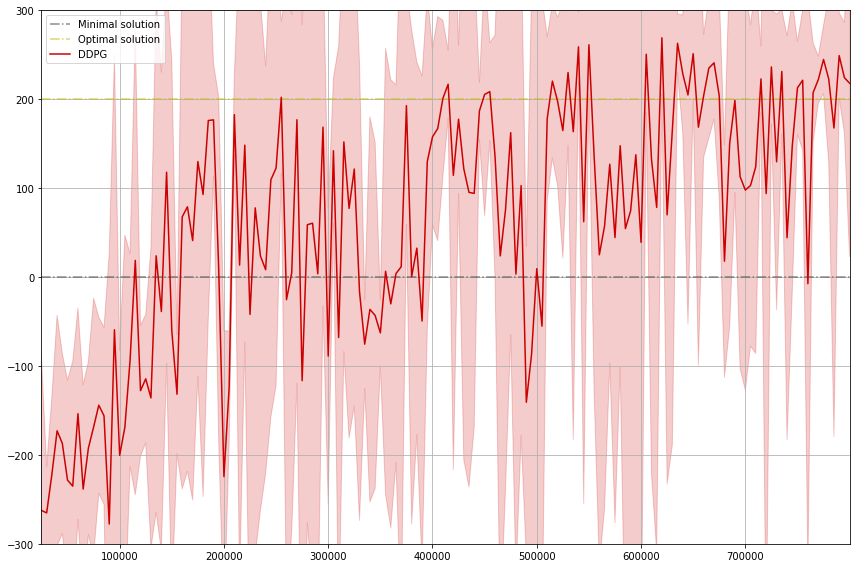

In [ ]:
xs, means, stds, labels = [], [], [], []

ddpg = DDPG(8, 2, tau=0.001, gamma=0.99, actor_lr=1e-3, critic_lr=1e-4)

x, mean, std = train(ddpg, timesteps=700_000, start_train=20_000, batch_size=64, act_noise=0.05,
                           buffer_size=int(1e6), test_every=5000, test_count=5) 

xs.append(x)
means.append(mean)
stds.append(std)
labels.append(f"DDPG")

final_mean, final_std = test(ddpg, episodes=25)
print(f"Agent mean score is {final_mean} with std {final_std}")

build_plot(xs, means, stds, labels)